# Preprocessing and Training

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
%matplotlib inline
sns.set(style="white", palette="muted", color_codes=True)

import statsmodels.api as sm
from functools import reduce

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score)
from sklearn.metrics import (auc, roc_curve, precision_recall_curve,
                             plot_precision_recall_curve, average_precision_score)
from sklearn.metrics import precision_recall_fscore_support

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline

import os
import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
#read the cvd_data_encoded csv file saved earlier
cvd_df = pd.read_csv('../data/cvd_data_encoded.csv')

In [3]:
cvd_df.head().T

,0,1,2,3,4
gender,1.0,0.00,0.00,0.00,1.00
age,44.0,70.00,73.00,79.00,59.00
sysbp,144.0,138.00,130.00,144.00,136.00
diabp,74.0,60.00,68.00,74.00,76.00
bmi,30.9,24.74,30.63,28.93,29.51
waistcircum,96.0,96.50,117.10,107.70,101.20
hdl,39.0,59.00,49.00,81.00,76.00
trigly,86.0,65.00,195.00,50.00,123.00
ldl,49.0,75.00,98.00,90.00,104.00
totchol,105.0,147.00,186.00,181.00,205.00


In [4]:
cvd_df.columns

Index(['gender', 'age', 'sysbp', 'diabp', 'bmi', 'waistcircum', 'hdl',
       'trigly', 'ldl', 'totchol', 'CVD_risk', 'pulse_cat', 'hypertension_cat',
       'waistcircum_cat', 'hdl_cat', 'trigly_cat', 'ldl_cat', 'totchol_cat',
       'diabetes_cat', 'kidney_cat', 'family_history_cat', 'smoking_cat',
       'gender_cat_Female', 'gender_cat_Male', 'age_cat_20s', 'age_cat_30s',
       'age_cat_40s', 'age_cat_50s', 'age_cat_60s', 'age_cat_70s & above',
       'ethnicity_cat_Black', 'ethnicity_cat_Hispanic',
       'ethnicity_cat_Mexican', 'ethnicity_cat_Other', 'ethnicity_cat_White',
       'income_cat_lower middle', 'income_cat_lowest',
       'income_cat_middle & over', 'bmi_cat_underweight', 'bmi_cat_ideal',
       'bmi_cat_overweight'],
      dtype='object')

## Dependent features

In our dataset, we kept the absolute features as well as the dummy features. It's expected to have features which are highly correlated that means which are some what linearly dependent with other features. These features contribute very less in predicting the output but increses the computational cost. So we have to find out the correlation between the features and remove the features which have correlation coefficient greater than a certain limit.

In [5]:
#set the threshold as 0.6 to drop out collinear features
threshold = 0.6

#create correlation matrix
corr_matrix = cvd_df.corr().abs()

#select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#find index of feature columns with correlation greater than 0.6
to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]

print('There are {} columns to drop with correlation > {}'.format(len(to_drop), threshold))

There are 12 columns to drop with correlation > 0.6


In [6]:
#get the names of columns to drop
to_drop

['waistcircum',
 'totchol',
 'hypertension_cat',
 'waistcircum_cat',
 'hdl_cat',
 'trigly_cat',
 'ldl_cat',
 'totchol_cat',
 'gender_cat_Female',
 'gender_cat_Male',
 'income_cat_lowest',
 'bmi_cat_overweight']

As it turns out, most of the categorical features that we created aren't contributing as much, so we will drop them.

In [7]:
#list all the column names
cvd_df.columns

Index(['gender', 'age', 'sysbp', 'diabp', 'bmi', 'waistcircum', 'hdl',
       'trigly', 'ldl', 'totchol', 'CVD_risk', 'pulse_cat', 'hypertension_cat',
       'waistcircum_cat', 'hdl_cat', 'trigly_cat', 'ldl_cat', 'totchol_cat',
       'diabetes_cat', 'kidney_cat', 'family_history_cat', 'smoking_cat',
       'gender_cat_Female', 'gender_cat_Male', 'age_cat_20s', 'age_cat_30s',
       'age_cat_40s', 'age_cat_50s', 'age_cat_60s', 'age_cat_70s & above',
       'ethnicity_cat_Black', 'ethnicity_cat_Hispanic',
       'ethnicity_cat_Mexican', 'ethnicity_cat_Other', 'ethnicity_cat_White',
       'income_cat_lower middle', 'income_cat_lowest',
       'income_cat_middle & over', 'bmi_cat_underweight', 'bmi_cat_ideal',
       'bmi_cat_overweight'],
      dtype='object')

In [8]:
#create objects X and y to store the data (after dropping correlated features) and the target value respectively.
X = cvd_df.drop(['CVD_risk', 'waistcircum', 'totchol','hypertension_cat',
                          'hdl_cat', 'trigly_cat', 'ldl_cat', 'totchol_cat',
                          'gender_cat_Female', 'gender_cat_Male', 'bmi_cat_underweight',
                          'bmi_cat_ideal', 'bmi_cat_overweight' ] , axis=1)
y = cvd_df['CVD_risk']

In [9]:
#print the first five rows
X.head()

,gender,age,sysbp,diabp,bmi,hdl,trigly,ldl,pulse_cat,waistcircum_cat,...,age_cat_60s,age_cat_70s & above,ethnicity_cat_Black,ethnicity_cat_Hispanic,ethnicity_cat_Mexican,ethnicity_cat_Other,ethnicity_cat_White,income_cat_lower middle,income_cat_lowest,income_cat_middle & over
0,1,44,144,74,30.90,39,86,49,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,70,138,60,24.74,59,65,75,0,1,...,0,1,0,0,0,0,1,0,0,1
2,0,73,130,68,30.63,49,195,98,0,1,...,0,1,0,0,0,0,1,1,0,0
3,0,79,144,74,28.93,81,50,90,0,1,...,0,1,0,0,0,0,1,0,1,0
4,1,59,136,76,29.51,76,123,104,0,0,...,0,0,1,0,0,0,0,1,0,0


## Split the data into train, validation and test sets

In [10]:
#split the dataset into train(60%), test(20%) and validation sets(20%)
X_tr, X_te, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
X_tr, X_va, y_train, y_val = train_test_split(X_tr, y_train, test_size=0.25, random_state=123)

In [11]:
#confirming the ratios of train, test and validation sets for X
print('Percent heldout for training:', round(100*(len(X_tr)/len(cvd_df)),0),'%')
print('Percent heldout for validation', round(100*(len(X_va)/len(cvd_df)),0),'%')
print('Percent heldout for testing:', round(100*(len(X_te)/len(cvd_df)),0),'%')

Percent heldout for training: 60.0 %
Percent heldout for validation 20.0 %
Percent heldout for testing: 20.0 %


In [12]:
#confirming the ratios of train, test and validation sets for y
print('Percent heldout for training:', round(100*(len(y_train)/len(cvd_df)),0),'%')
print('Percent heldout for validation', round(100*(len(y_val)/len(cvd_df)),0),'%')
print('Percent heldout for testing:', round(100*(len(y_test)/len(cvd_df)),0),'%')

Percent heldout for training: 60.0 %
Percent heldout for validation 20.0 %
Percent heldout for testing: 20.0 %


## Data Normalization

In [13]:
#since each feature is on a different scale, normalization is required. split the data based on the columns
#that need scaling
to_scale = ['age', 'sysbp', 'diabp', 'bmi', 'hdl', 'trigly','ldl']
not_to_scale = ['gender', 'pulse_cat', 'waistcircum_cat', 'diabetes_cat', 'kidney_cat',
                'family_history_cat', 'smoking_cat', 'age_cat_20s', 'age_cat_30s',
                'age_cat_40s', 'age_cat_50s', 'age_cat_60s', 'age_cat_70s & above',
                'ethnicity_cat_Black', 'ethnicity_cat_Hispanic', 'ethnicity_cat_Mexican',
                'ethnicity_cat_Other', 'ethnicity_cat_White','income_cat_lower middle',
                'income_cat_lowest', 'income_cat_middle & over']

In [14]:
#normalize the features for X_tr and call the scaled dataset X_train so that each column/feature/variable will
#have μ = 0 and σ = 1
scaler = StandardScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(X_tr[to_scale]),columns=X_tr[to_scale].columns).reset_index(drop=True)
X_train=pd.concat([scaled_train, X_tr[not_to_scale].reset_index(drop=True)], axis=1)

In [15]:
#normalize the features for X_va and call the scaled dataset X_val so that each column/feature/variable will
#have μ = 0 and σ = 1
scaled_val = pd.DataFrame(scaler.transform(X_va[to_scale]),columns=X_va[to_scale].columns).reset_index(drop=True)
X_val=pd.concat([scaled_val, X_va[not_to_scale].reset_index(drop=True)], axis=1)

In [16]:
#normalize the features for X_te and call the scaled dataset X_test so that each column/feature/variable will
#have μ = 0 and σ = 1
scaled_test = pd.DataFrame(scaler.transform(X_te[to_scale]),columns=X_te[to_scale].columns).reset_index(drop=True)
X_test=pd.concat([scaled_test, X_te[not_to_scale].reset_index(drop=True)], axis=1)

In [17]:
#print the first five rows for X_train
X_train.head().T

,0,1,2,3,4
age,-1.491921,1.516454,-1.547632,-0.934815,-1.659053
sysbp,-0.751932,-0.306587,-0.529260,-0.417924,-1.531285
diabp,-0.750008,-0.100995,-0.425502,1.197030,-1.074514
bmi,1.086766,0.830579,-0.298973,0.051829,-1.520228
hdl,-0.842354,1.022038,-0.283037,-0.780208,0.897745
trigly,-0.232706,-0.395660,2.078267,1.293129,-0.899333
ldl,0.936988,1.441285,-0.744002,1.665417,-0.912101
gender,0.000000,1.000000,1.000000,0.000000,1.000000
pulse_cat,0.000000,0.000000,0.000000,0.000000,0.000000
waistcircum_cat,1.000000,1.000000,0.000000,1.000000,0.000000


In [18]:
#print the first five rows for X_val
X_val.head().T

,0,1,2,3,4
age,1.460743,-0.266287,0.179398,-0.767683,-1.269079
sysbp,-0.195251,0.138757,-0.751932,-1.753957,0.250093
diabp,0.061258,1.034777,0.710270,-1.723527,-0.425502
bmi,1.027086,0.022716,2.495794,-0.792424,-0.521681
hdl,-0.780208,-1.153086,-0.655915,0.959891,-0.904501
trigly,1.115361,0.374665,-0.766008,-1.165984,1.144989
ldl,-0.267722,2.113681,-0.015573,-1.192266,1.077071
gender,1.000000,0.000000,1.000000,1.000000,0.000000
pulse_cat,0.000000,0.000000,0.000000,0.000000,0.000000
waistcircum_cat,1.000000,1.000000,1.000000,0.000000,1.000000


In [19]:
#print the first five rows for X_test
X_test.head().T

,0,1,2,3,4
age,1.516454,-1.213368,-0.823393,0.847926,-1.603342
sysbp,2.588152,-0.640596,-0.306587,1.474791,-0.195251
diabp,0.385764,0.710270,-0.263248,0.548017,-1.885780
bmi,-1.288786,-1.568263,0.997974,-1.365934,-0.486746
hdl,-0.283037,2.389259,-0.158744,-0.966647,-0.718062
trigly,0.641316,-0.958589,-0.766008,1.159803,3.026359
ldl,0.516741,-0.659953,0.012444,0.488724,-0.687969
gender,1.000000,1.000000,1.000000,0.000000,0.000000
pulse_cat,0.000000,0.000000,0.000000,0.000000,0.000000
waistcircum_cat,0.000000,0.000000,0.000000,1.000000,1.000000


## Naive baseline

Now that the dataset is split into training, testing and validation sets, let's try a naive baseline for comparison

In [20]:
np.random.seed(123)
naive_guess = np.random.binomial(1, p=np.mean(y), size=len(y_val))
naive_guess[:10], naive_guess.sum()

(array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]), 315)

In [21]:
print('Naive Baseline')
roc = roc_auc_score(y_val, np.repeat(np.mean(y), len(y_val)))
print('ROC AUC: {}'.format(round(roc, 4)))

for metric in [precision_score, recall_score, f1_score]:
    print('{}: {}'.format((metric.__name__), round(metric(y_val, naive_guess), 4)))

Naive Baseline
ROC AUC: 0.5
precision_score: 0.0952
recall_score: 0.0955
f1_score: 0.0954


We can see that these metrics are very poor! With no machine learning, we are only able to identify 10% of the indivisuals with CVD risk and only 10% of those predicted are actually true. A naive approach clearly does not provide much value.

In [22]:
print('The percentage of patients with CVD risk in training data:', round(100 * round(np.mean(y), 4)),'%')

The percentage of patients with CVD risk in training data: 11 %


## Machine learning

### Base Model Evaluation

Now we need to see if machine learning is up to the task of improving on these predictions. We'll start simple, using a classification models to assess without hyperparaneter tuning on bith training and validation sets to understand tehir performance.

For an imbalanced classification problem, there are a number of metrics to consider:

- Receiver Operating Characteristic Area Under the Curve (ROC AUC): a measure between 0 and 1 comparing the performance of the classifier when predicting probabilities across a range of thresholds.
- Precision Score: number of true positives divided by the total number of positives predicted
- Recall Score: number of true positives divided by the total number of actual positives in the data
- F1 Score: Harmonic mean of precision and recall
- Precision Recall Area Under the Curve (PR AUC): shows the tradeoff between precision and recall for different thresholds.

In [23]:
def model_fit(alg, X_train, X_val, y_train, y_val, plot=True):
    
    #fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train)
    y_train_predprob = alg.predict_proba(X_train)[:,1]
    
    y_val_pred = alg.predict(X_val)
    y_val_predprob = alg.predict_proba(X_val)[:,1]
    
    #get precision, recall and threshold on train and validation sets:
    prf_train=precision_recall_fscore_support(y_train, y_train_pred, pos_label=1, average='binary')
    prf_val=precision_recall_fscore_support(y_val, y_val_pred, pos_label=1, average='binary')
    
    #get average precision on train and validation sets:
    area_prc_train=average_precision_score(y_train, y_train_predprob, average=None)
    area_prc_val=average_precision_score(y_val, y_val_predprob, average=None)
    
    precision_train, recall_train, thr_train = precision_recall_curve(y_train, y_train_predprob, pos_label=1)
    precision_val, recall_val, thr_val = precision_recall_curve(y_val, y_val_predprob, pos_label=1)
    
    #get get positives and true positives on train and validation sets:
    fp_tp_train = roc_curve(y_train, y_train_pred)
    fp_tp_val = roc_curve(y_val, y_val_pred) 
    
    print ("Model report on training data:")
    print ("Train: Precision: %.4f" %(prf_train[0]))
    print ("Train: Recall : %.4f" %(prf_train[1]))
    print ("Average Precision (Train): %.4f" %(area_prc_train))
    print ("ROC AUC (Train): %.4f" %(auc(fp_tp_train[0], fp_tp_train[1])))
    print('Train Accuracy: %.4f' %(accuracy_score(alg.predict(X_train),y_train)))
    print ("\nModel report on validation data:")
    print ("Validation: Precision: %.4f" %(prf_val[0]))
    print ("Validation: Recall : %.4f" %(prf_val[1]))
    print ("Average Precision (Validation): %.4f" % (area_prc_val))
    print ("ROC AUC (Validation): %.4f" %(auc(fp_tp_val[0], fp_tp_val[1])))
    print('Validation Accuracy: %0.4f' %(accuracy_score(alg.predict(X_val),y_val)))
    
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(recall_val, precision_val, color='coral',label=' Validation PR-Curve')
        plt.plot(recall_train, precision_train, color='green',label=' Train PR-Curve')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve', fontsize=16)
        plt.legend(loc="lower left")
        plt.show()

In [24]:
def plot_results(targets,predictions,title):
    
    #plot barplots of precision and recall for both classes for training and test sets:
    tn, fp, fn, tp = confusion_matrix(targets,predictions).ravel()

    n_precision = tn/(tn+fn)
    n_recall = tn/(tn+fp)
        
    p_precision = tp/(tp+fp)
    p_recall = tp/(tp+fn)

    precision = [n_precision, p_precision]
    recall = [n_recall, p_recall]
      
    k = 0.1
    ax.bar([2+k,5+k],precision,color='#0085f9')
    ax.bar([3-k,6-k],recall,color='#00176d')
    ax.set_xticks([2.5,5.5])
    ax.set_xticklabels(['No_CVD_Risk', 'CVD_Risk'],fontsize=14)
    ax.set_xlim([1,7])
    ax.set_ylim([0,1.3])
    ax.legend(['Precision','Recall'],fontsize=12)
    ax.set_title(title,fontsize=16)
    plt.tight_layout()

#### Logistic Regression

Let's use logistic regression in order to see baseline performance on this problem.

Model report on training data:
Train: Precision: 0.5593
Train: Recall : 0.1549
Average Precision (Train): 0.4235
ROC AUC (Train): 0.5697
Train Accuracy: 0.8915

Model report on validation data:
Validation: Precision: 0.5316
Validation: Recall : 0.1338
Average Precision (Validation): 0.4140
ROC AUC (Validation): 0.5597
Validation Accuracy: 0.8934


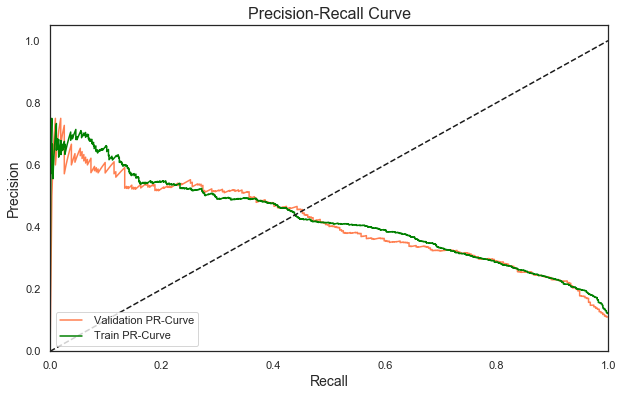

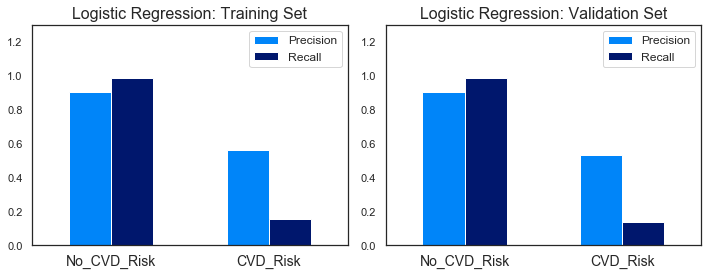

In [25]:
#fit logistic regression and predict y
lr = LogisticRegression(random_state=42)
model_fit(lr, X_train, X_val, y_train, y_val)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
plot_results(y_train,lr.predict(X_train),'Logistic Regression: Training Set')
ax = fig.add_subplot(1,2,2)
plot_results(y_val,lr.predict(X_val),'Logistic Regression: Validation Set')

Recall on the positive CVD cases is fairly low (about 15%) for both the training and test sets, however, the precision  is  good (about 55%) for both the training and test sets. The model seems to be good at correctly predicting cases with no CVD risk but is excessively likely to predict cases as negative.
One postive thing about this model is that the training dataset results closely match the validation set results, implying that model is neither underfitting nor overfitting.

### Support Vector Classifier

Now, let's evaluate the performance of Support Vector Classifier.

Model report on training data:
Train: Precision: 0.8824
Train: Recall : 0.1077
Average Precision (Train): 0.6658
ROC AUC (Train): 0.5529
Train Accuracy: 0.8983

Model report on validation data:
Validation: Precision: 0.5435
Validation: Recall : 0.0796
Average Precision (Validation): 0.3799
ROC AUC (Validation): 0.5357
Validation Accuracy: 0.8930


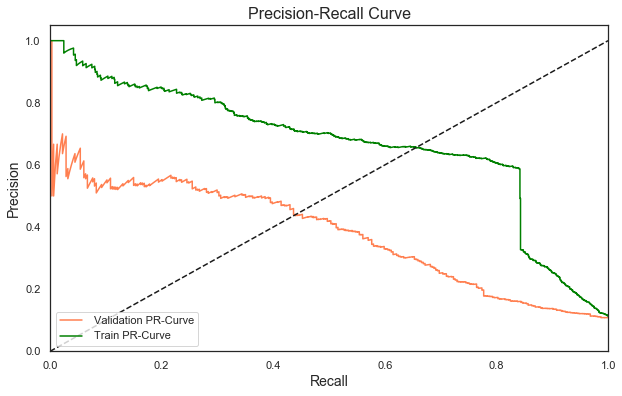

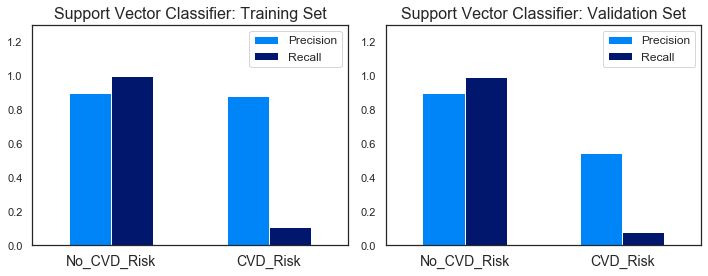

In [26]:
#fit support vector classifier and predict y
svc = SVC(random_state=42, probability=True)  
model_fit(svc,X_train, X_val, y_train, y_val, True)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
plot_results(y_train,svc.predict(X_train),'Support Vector Classifier: Training Set')
ax = fig.add_subplot(1,2,2)
plot_results(y_val,svc.predict(X_val),'Support Vector Classifier: Validation Set')

Support Vector Classifier is overfitting the training data as can be observed by the higher precision for training dataset. It is also showing a much lower recall on CVD risk cases.

### Random Forest Classifier

Model report on training data:
Train: Precision: 1.0000
Train: Recall : 1.0000
Average Precision (Train): 1.0000
ROC AUC (Train): 1.0000
Train Accuracy: 1.0000

Model report on validation data:
Validation: Precision: 0.5783
Validation: Recall : 0.1529
Average Precision (Validation): 0.4143
ROC AUC (Validation): 0.5697
Validation Accuracy: 0.8961


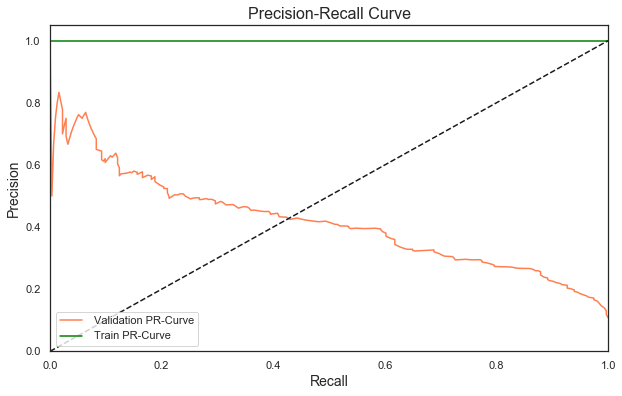

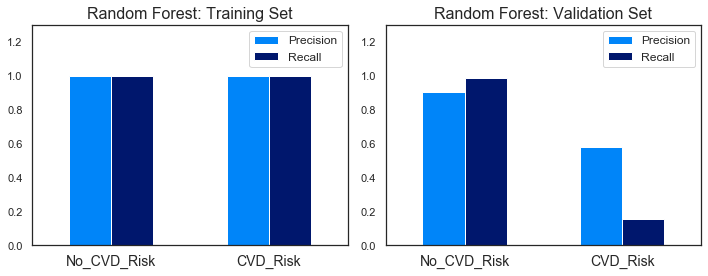

In [27]:
#fit random forest classifier and predict y
rf = RandomForestClassifier(random_state=42, n_estimators = 300)
model_fit(rf,X_train, X_val, y_train, y_val, True)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
plot_results(y_train,rf.predict(X_train),'Random Forest: Training Set')
ax = fig.add_subplot(1,2,2)
plot_results(y_val,rf.predict(X_val),'Random Forest: Validation Set')

Random Forest is frossly overfitting the training dataset and is showing 100% recall and precision. The performance on the validation set is similar to that of Logistic Regression.

Model report on training data:
Train: Precision: 0.7047
Train: Recall : 0.2913
Average Precision (Train): 0.5265
ROC AUC (Train): 0.6379
Train Accuracy: 0.9068

Model report on validation data:
Validation: Precision: 0.5043
Validation: Recall : 0.1847
Average Precision (Validation): 0.2986
ROC AUC (Validation): 0.5813
Validation Accuracy: 0.8920


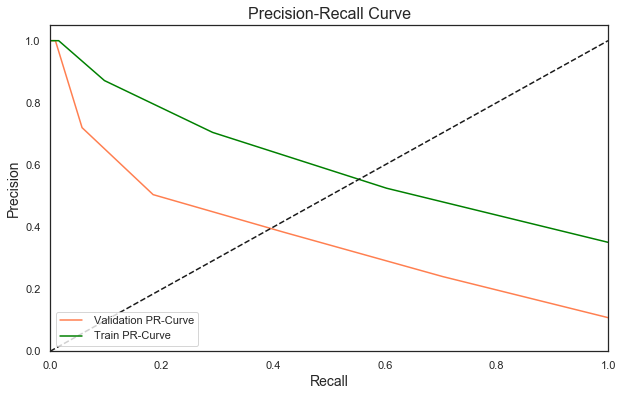

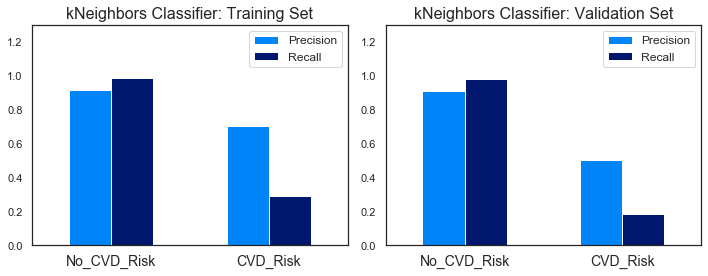

In [29]:
#fit lkneighbors classifier and predict y
knn = KNeighborsClassifier()
model_fit(knn, X_train, X_val, y_train, y_val, True)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
plot_results(y_train,knn.predict(X_train),'kNeighbors Classifier: Training Set')
ax = fig.add_subplot(1,2,2)
plot_results(y_val,knn.predict(X_val),'kNeighbors Classifier: Validation Set')

Again, the model seems to be overfitting the training dataset but shows a better recall on the test set compared to the other models.

Next, we will compare the metrics (accuracy, precision, recall, f1, ROC AUC, PRC AUC) for all the models and plot their precision recall curves.

In [30]:
#define a function to plot confusion matrix
def confusion_matrix_plot(model):
    y_pred = model.predict(X_val)
    model_matrix = confusion_matrix(y_val,y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=model_matrix)
    plt.show()

In [31]:
#define a function to show and plot the metrics for different models
def show_metrics(X_tr, y_tr, title):
    MLA = [lr, knn, rf, svc]
    MLA_columns = []
    MLA_compare = pd.DataFrame(columns = MLA_columns)
    row_index = 0
    plt.figure(figsize=(10,6))
    for alg in MLA:
        pred = alg.fit(X_tr, y_tr).predict(X_val)
        pred_prob = alg.predict_proba(X_val)
        fp, tp, th = roc_curve(y_val, pred)     
        y_score = pred_prob[:,1]
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index,'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'Accuracy'] = accuracy_score(y_val, pred)
        MLA_compare.loc[row_index, 'Precision'] = precision_score(y_val, pred)
        MLA_compare.loc[row_index, 'Recall'] = recall_score(y_val, pred)
        MLA_compare.loc[row_index, 'F-1 score'] = f1_score(y_val, pred)
        MLA_compare.loc[row_index, 'ROC_AUC'] = auc(fp, tp)
        
        alg_precision, alg_recall, alg_thresholds = precision_recall_curve(y_val, y_score)
        MLA_compare.loc[row_index, 'PRC_AUC'] = auc(alg_recall, alg_precision)
        
        plt.step(alg_recall, alg_precision, marker='.', markersize=1, label=MLA_name)
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title(title, fontsize=16)
        plt.legend(fontsize=12)
        
        row_index+=1
        
    return(MLA_compare)    

,MLA Name,Accuracy,Precision,Recall,F-1 score,ROC_AUC,PRC_AUC
0,LogisticRegression,0.893375,0.531646,0.133758,0.213740,0.559720,0.411065
1,KNeighborsClassifier,0.891994,0.504348,0.184713,0.270396,0.581327,0.373097
2,RandomForestClassifier,0.896135,0.578313,0.152866,0.241814,0.569661,0.415245
3,SVC,0.893030,0.543478,0.079618,0.138889,0.535745,0.377733


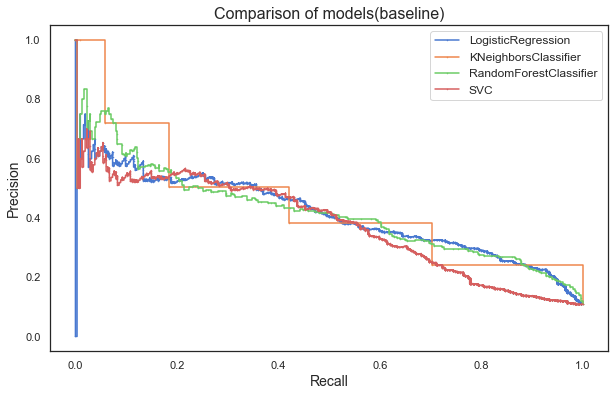

In [32]:
show_metrics(X_train, y_train, 'Comparison of models(baseline)')

## Resampling Strategies

Since our positive CVD risk cases comprise 11% of the total cases,we will use some techniques to handle this highly unbalanced dataset, with a focus on following resampling methods:
- Random oversampling: randomly duplicate examples in the majority class
- Random undersampling: randomly delete examples in the minority class
- Synthetic Minority Oversampling Technique(SMOTE): selects examples that are close in the feature space, draws a line between the examples and draws a new sample at a point along that line
- SMOTEENN: combines over- and under-sampling using SMOTE and Edited Nearest Neighbours

In [33]:
ros = RandomOverSampler()
rus = RandomUnderSampler()
smote = SMOTE()
smoteenn = SMOTEENN()
columns = X_train.columns

In [34]:
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('KNeighbors Classifier', KNeighborsClassifier()))
models.append(('RandomForest Classifier', RandomForestClassifier()))
models.append(('Support Vector Classifier', SVC(probability=True)))

In [35]:
def resamp_eval(resamp_alg, X_tr, y_tr):
    names = []
    for name, model in models:
        names.append(name)
        print(name)
        model_fit(model, X_tr, X_val, y_tr, y_val, True)

Now we will perform the comparison of models using various sampling techniques.

### Oversampling

In [36]:
#use oversampling to fit the models and predict y
os_X, os_y = ros.fit_sample(X_train, y_train)
os_X = pd.DataFrame(data=os_X, columns=columns )
os_y = pd.DataFrame(data=os_y, columns=['CVD_risk'])

Logistic Regression
Model report on training data:
Train: Precision: 0.7600
Train: Recall : 0.8091
Average Precision (Train): 0.8298
ROC AUC (Train): 0.7768
Train Accuracy: 0.7768

Model report on validation data:
Validation: Precision: 0.2786
Validation: Recall : 0.8057
Average Precision (Validation): 0.4006
ROC AUC (Validation): 0.7761
Validation Accuracy: 0.7529


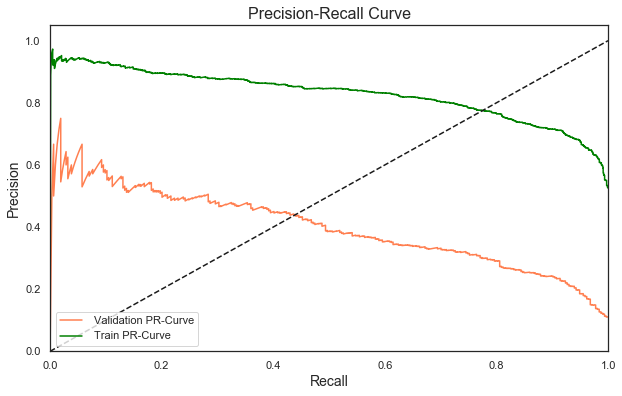

KNeighbors Classifier
Model report on training data:
Train: Precision: 0.8759
Train: Recall : 0.9992
Average Precision (Train): 0.9975
ROC AUC (Train): 0.9288
Train Accuracy: 0.9288

Model report on validation data:
Validation: Precision: 0.2747
Validation: Recall : 0.5764
Average Precision (Validation): 0.2462
ROC AUC (Validation): 0.6957
Validation Accuracy: 0.7892


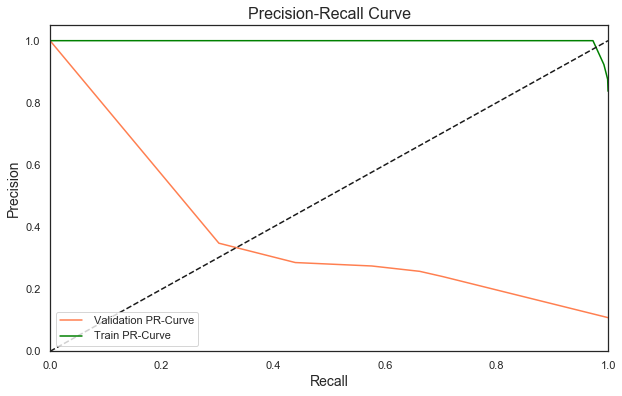

RandomForest Classifier
Model report on training data:
Train: Precision: 1.0000
Train: Recall : 1.0000
Average Precision (Train): 1.0000
ROC AUC (Train): 1.0000
Train Accuracy: 1.0000

Model report on validation data:
Validation: Precision: 0.4847
Validation: Recall : 0.2516
Average Precision (Validation): 0.3924
ROC AUC (Validation): 0.6095
Validation Accuracy: 0.8899


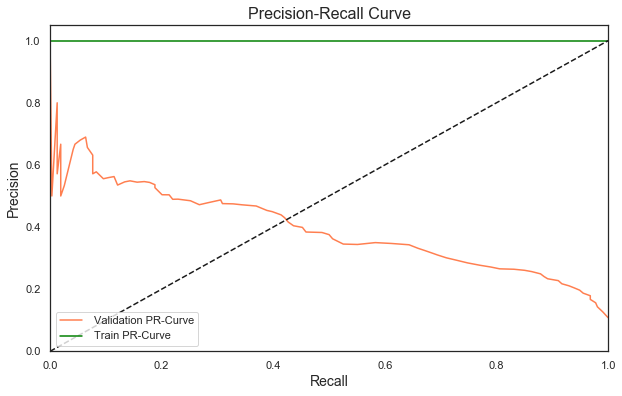

Support Vector Classifier
Model report on training data:
Train: Precision: 0.8327
Train: Recall : 0.9271
Average Precision (Train): 0.9101
ROC AUC (Train): 0.8704
Train Accuracy: 0.8704

Model report on validation data:
Validation: Precision: 0.2920
Validation: Recall : 0.7197
Average Precision (Validation): 0.3671
ROC AUC (Validation): 0.7538
Validation Accuracy: 0.7805


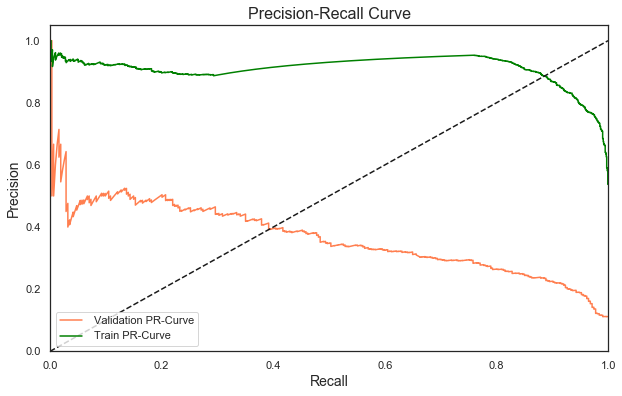

In [37]:
resamp_eval(ros, os_X, os_y)

,MLA Name,Accuracy,Precision,Recall,F-1 score,ROC_AUC,PRC_AUC
0,LogisticRegression,0.752933,0.278634,0.805732,0.414075,0.776125,0.397598
1,KNeighborsClassifier,0.789165,0.274659,0.576433,0.372045,0.695724,0.370516
2,RandomForestClassifier,0.890614,0.490323,0.242038,0.324094,0.605733,0.401148
3,SVC,0.780538,0.291990,0.719745,0.415441,0.753835,0.364986


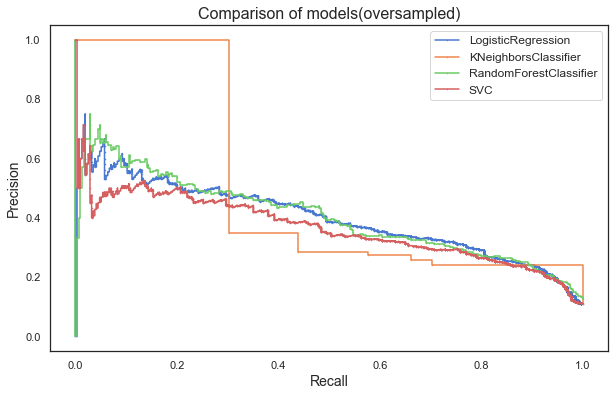

In [38]:
show_metrics(os_X, os_y, 'Comparison of models(oversampled)')

Oversampling has resulted in a huge improvement in recall but a reduction in precision also known as precision/recall tradeoff. The logistic regression model in particular stands out sue to its high recall.

### Undersampling

In [39]:
#use undersampling to fit the models and predict y
us_X, us_y = rus.fit_sample(X_train, y_train)
us_X = pd.DataFrame(data=us_X, columns=columns )
us_y = pd.DataFrame(data=us_y, columns=['CVD_risk'])

Logistic Regression
Model report on training data:
Train: Precision: 0.7545
Train: Recall : 0.8103
Average Precision (Train): 0.8376
ROC AUC (Train): 0.7733
Train Accuracy: 0.7733

Model report on validation data:
Validation: Precision: 0.2791
Validation: Recall : 0.8089
Average Precision (Validation): 0.3964
ROC AUC (Validation): 0.7775
Validation Accuracy: 0.7529


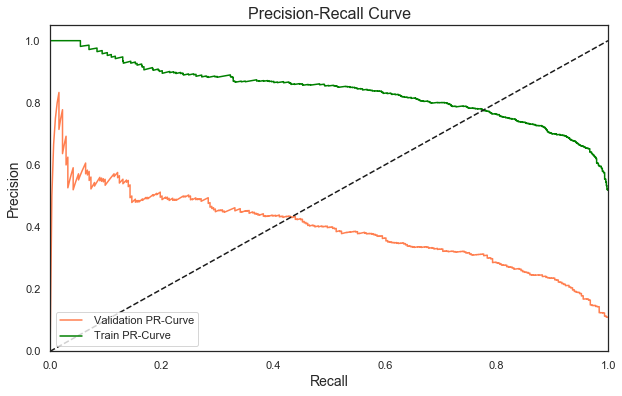

KNeighbors Classifier
Model report on training data:
Train: Precision: 0.7918
Train: Recall : 0.8113
Average Precision (Train): 0.8586
ROC AUC (Train): 0.7990
Train Accuracy: 0.7990

Model report on validation data:
Validation: Precision: 0.2587
Validation: Recall : 0.7325
Average Precision (Validation): 0.2787
ROC AUC (Validation): 0.7387
Validation Accuracy: 0.7436


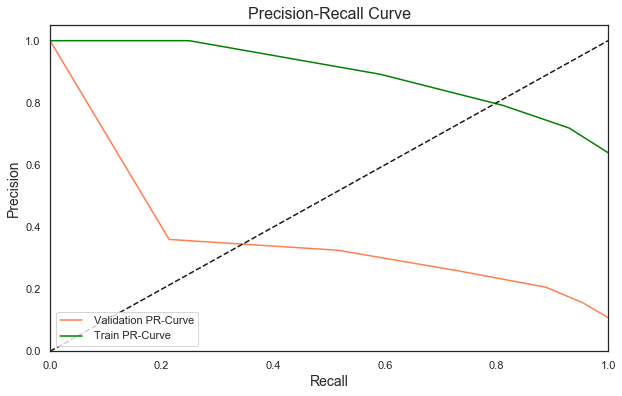

RandomForest Classifier
Model report on training data:
Train: Precision: 1.0000
Train: Recall : 1.0000
Average Precision (Train): 1.0000
ROC AUC (Train): 1.0000
Train Accuracy: 1.0000

Model report on validation data:
Validation: Precision: 0.2737
Validation: Recall : 0.8089
Average Precision (Validation): 0.4008
ROC AUC (Validation): 0.7740
Validation Accuracy: 0.7467


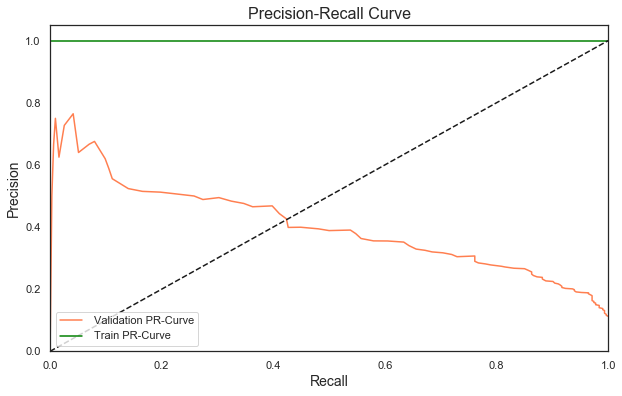

Support Vector Classifier
Model report on training data:
Train: Precision: 0.7907
Train: Recall : 0.8718
Average Precision (Train): 0.8983
ROC AUC (Train): 0.8205
Train Accuracy: 0.8205

Model report on validation data:
Validation: Precision: 0.2603
Validation: Recall : 0.8280
Average Precision (Validation): 0.3640
ROC AUC (Validation): 0.7710
Validation Accuracy: 0.7264


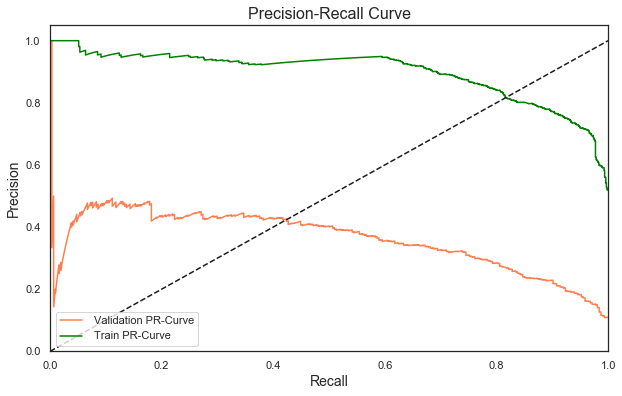

In [40]:
resamp_eval(rus, us_X, us_y)

,MLA Name,Accuracy,Precision,Recall,F-1 score,ROC_AUC,PRC_AUC
0,LogisticRegression,0.752933,0.279121,0.808917,0.415033,0.777524,0.393531
1,KNeighborsClassifier,0.743616,0.258718,0.732484,0.382377,0.738727,0.366333
2,RandomForestClassifier,0.741546,0.267380,0.796178,0.400320,0.765543,0.415391
3,SVC,0.726363,0.260260,0.828025,0.396040,0.771017,0.361901


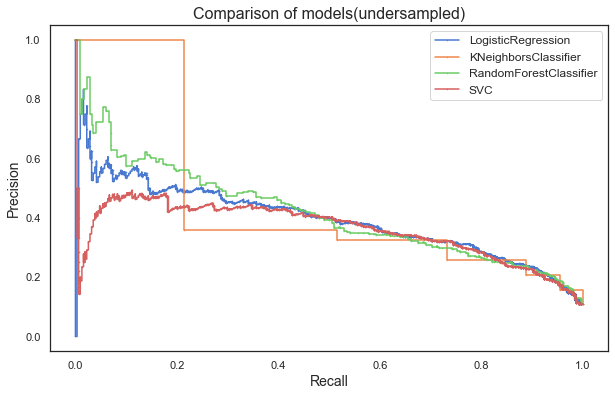

In [41]:
show_metrics(us_X, us_y, 'Comparison of models(undersampled)')

Undersampling shows a similar improvement in recall as well.

### SMOTE

In [42]:
#use SMOTE to fit the models and predict y
smote_X, smote_y = smote.fit_sample(X_train, y_train)
smote_X = pd.DataFrame(data=smote_X, columns=columns )
smote_y = pd.DataFrame(data=smote_y, columns=['CVD_risk'])

Logistic Regression
Model report on training data:
Train: Precision: 0.8627
Train: Recall : 0.8713
Average Precision (Train): 0.9412
ROC AUC (Train): 0.8664
Train Accuracy: 0.8664

Model report on validation data:
Validation: Precision: 0.3290
Validation: Recall : 0.5605
Average Precision (Validation): 0.3873
ROC AUC (Validation): 0.7108
Validation Accuracy: 0.8285


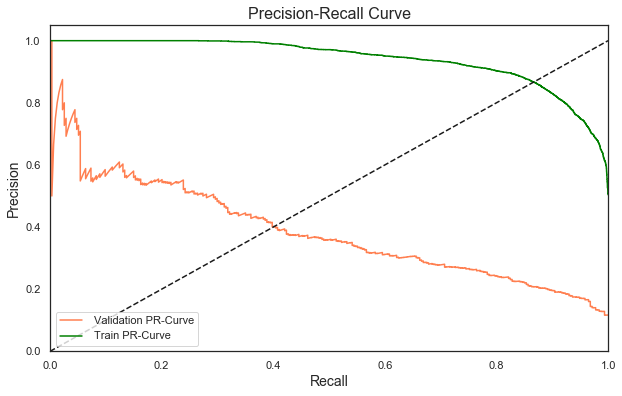

KNeighbors Classifier
Model report on training data:
Train: Precision: 0.8515
Train: Recall : 0.9990
Average Precision (Train): 0.9947
ROC AUC (Train): 0.9123
Train Accuracy: 0.9123

Model report on validation data:
Validation: Precision: 0.2627
Validation: Recall : 0.6433
Average Precision (Validation): 0.2732
ROC AUC (Validation): 0.7119
Validation Accuracy: 0.7657


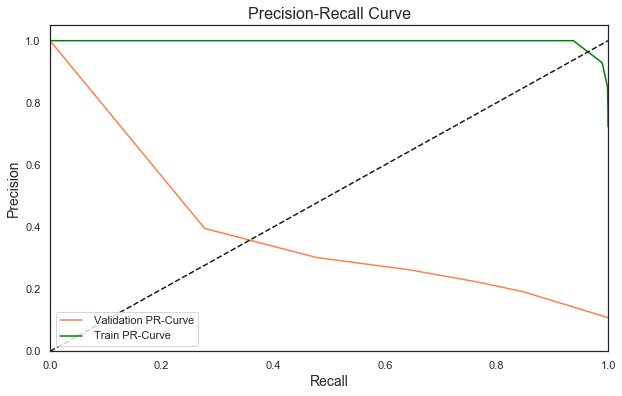

RandomForest Classifier
Model report on training data:
Train: Precision: 1.0000
Train: Recall : 1.0000
Average Precision (Train): 1.0000
ROC AUC (Train): 1.0000
Train Accuracy: 1.0000

Model report on validation data:
Validation: Precision: 0.3994
Validation: Recall : 0.4299
Average Precision (Validation): 0.3512
ROC AUC (Validation): 0.6757
Validation Accuracy: 0.8682


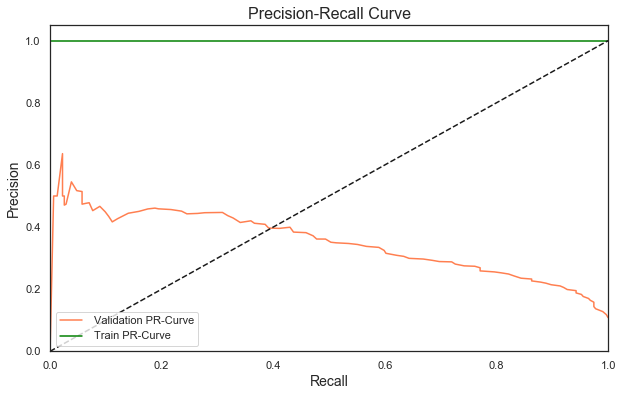

Support Vector Classifier
Model report on training data:
Train: Precision: 0.9100
Train: Recall : 0.9176
Average Precision (Train): 0.9715
ROC AUC (Train): 0.9134
Train Accuracy: 0.9134

Model report on validation data:
Validation: Precision: 0.3647
Validation: Recall : 0.4936
Average Precision (Validation): 0.3593
ROC AUC (Validation): 0.6946
Validation Accuracy: 0.8520


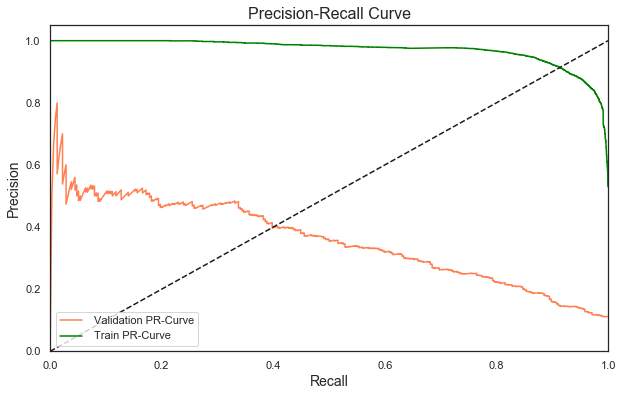

In [43]:
resamp_eval(smote, smote_X, smote_y)

,MLA Name,Accuracy,Precision,Recall,F-1 score,ROC_AUC,PRC_AUC
0,LogisticRegression,0.828502,0.328972,0.560510,0.414605,0.710789,0.385343
1,KNeighborsClassifier,0.765700,0.262679,0.643312,0.373038,0.711942,0.379627
2,RandomForestClassifier,0.864389,0.390582,0.449045,0.417778,0.681953,0.363774
3,SVC,0.851967,0.364706,0.493631,0.419486,0.694571,0.356360


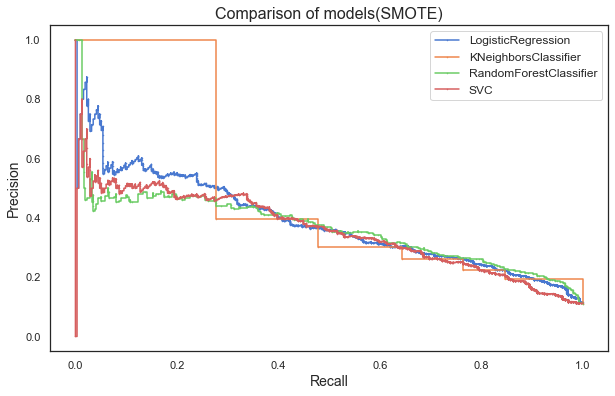

In [44]:
show_metrics(smote_X, smote_y, 'Comparison of models(SMOTE)')

Unfortunately, SMOTE technique did not perform as well as the undersampling and oversampling techniques.

### SMOTEENN

In [45]:
#use SMOTEENN to fit the models and predict y
smoteenn_X, smoteenn_y = smoteenn.fit_sample(X_train, y_train)
smoteenn_X = pd.DataFrame(data=smoteenn_X, columns=columns )
smoteenn_y = pd.DataFrame(data=smoteenn_y, columns=['CVD_risk'])

Logistic Regression
Model report on training data:
Train: Precision: 0.9335
Train: Recall : 0.9338
Average Precision (Train): 0.9819
ROC AUC (Train): 0.9197
Train Accuracy: 0.9221

Model report on validation data:
Validation: Precision: 0.2742
Validation: Recall : 0.7675
Average Precision (Validation): 0.3960
ROC AUC (Validation): 0.7603
Validation Accuracy: 0.7547


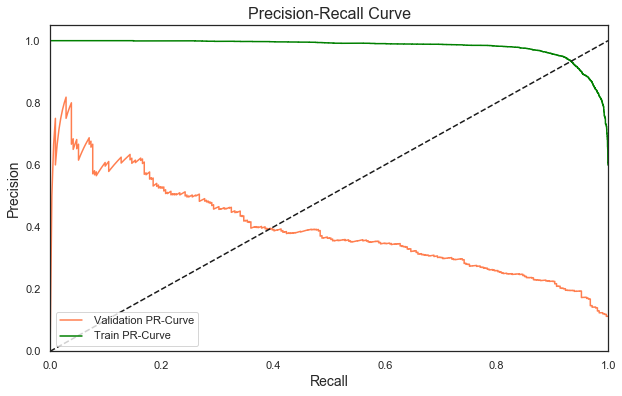

KNeighbors Classifier
Model report on training data:
Train: Precision: 0.9690
Train: Recall : 1.0000
Average Precision (Train): 0.9998
ROC AUC (Train): 0.9773
Train Accuracy: 0.9812

Model report on validation data:
Validation: Precision: 0.2292
Validation: Recall : 0.7994
Average Precision (Validation): 0.2548
ROC AUC (Validation): 0.7364
Validation Accuracy: 0.6870


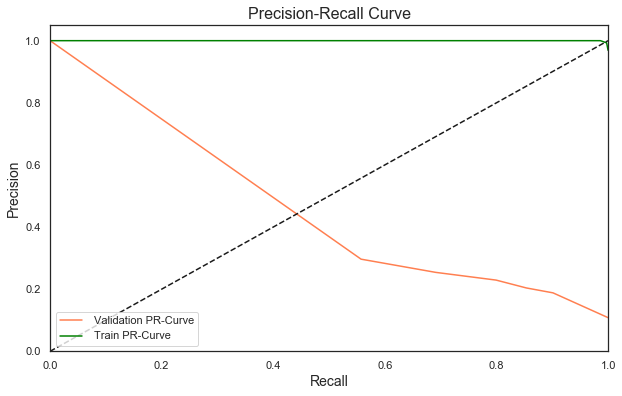

RandomForest Classifier
Model report on training data:
Train: Precision: 1.0000
Train: Recall : 1.0000
Average Precision (Train): 1.0000
ROC AUC (Train): 1.0000
Train Accuracy: 1.0000

Model report on validation data:
Validation: Precision: 0.2752
Validation: Recall : 0.6879
Average Precision (Validation): 0.3676
ROC AUC (Validation): 0.7338
Validation Accuracy: 0.7698


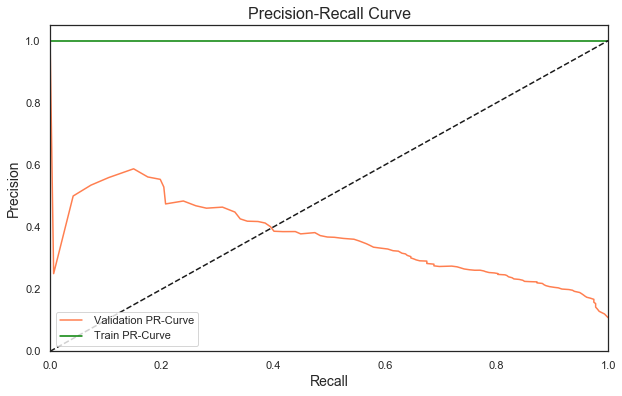

Support Vector Classifier
Model report on training data:
Train: Precision: 0.9641
Train: Recall : 0.9658
Average Precision (Train): 0.9936
ROC AUC (Train): 0.9574
Train Accuracy: 0.9589

Model report on validation data:
Validation: Precision: 0.2824
Validation: Recall : 0.7293
Average Precision (Validation): 0.3798
ROC AUC (Validation): 0.7520
Validation Accuracy: 0.7698


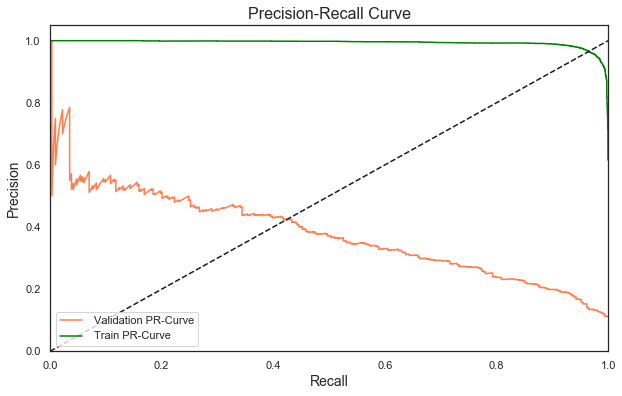

In [46]:
resamp_eval(smoteenn, smoteenn_X, smoteenn_y)

,MLA Name,Accuracy,Precision,Recall,F-1 score,ROC_AUC,PRC_AUC
0,LogisticRegression,0.754658,0.274175,0.767516,0.404023,0.760306,0.393166
1,KNeighborsClassifier,0.687026,0.229224,0.799363,0.356281,0.736369,0.460044
2,RandomForestClassifier,0.768806,0.279156,0.716561,0.401786,0.745858,0.359716
3,SVC,0.769841,0.282367,0.729299,0.407111,0.752034,0.377690


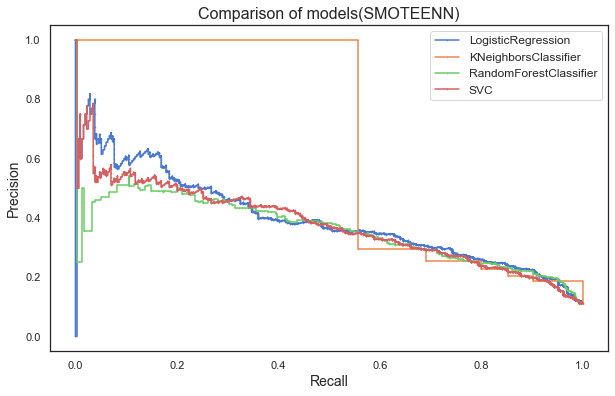

In [47]:
show_metrics(smoteenn_X, smoteenn_y, 'Comparison of models(SMOTEENN)')

SMOTEENN worked better than SMOTE technique but the best recall scores.

Based on the recall score, both undersampling and oversampling show similar performance with Logistic Regression. SMOTEEN technique shoed the best performance with KNeighbors Classifier. Oversampling and undersampling showed the best results with Random Forest and SVC, respectively. We will now perform hyperparameter tuning on these models with the appropriate sampling techniques.

In [48]:
#define a function to plot precision recall curves for different models for different sampling sampling techniques
def resample_plots(X_sam, y_sam, label):
    pred_sam = model.fit(X_sam, y_sam).predict_proba(X_val)
    y_score_sam = pred_sam[:,1]
    model_precision_sam, model_recall_sam, _ = precision_recall_curve(y_val, y_score_sam)
    plt.step(model_recall_sam, model_precision_sam, marker='.', label=label)      
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()

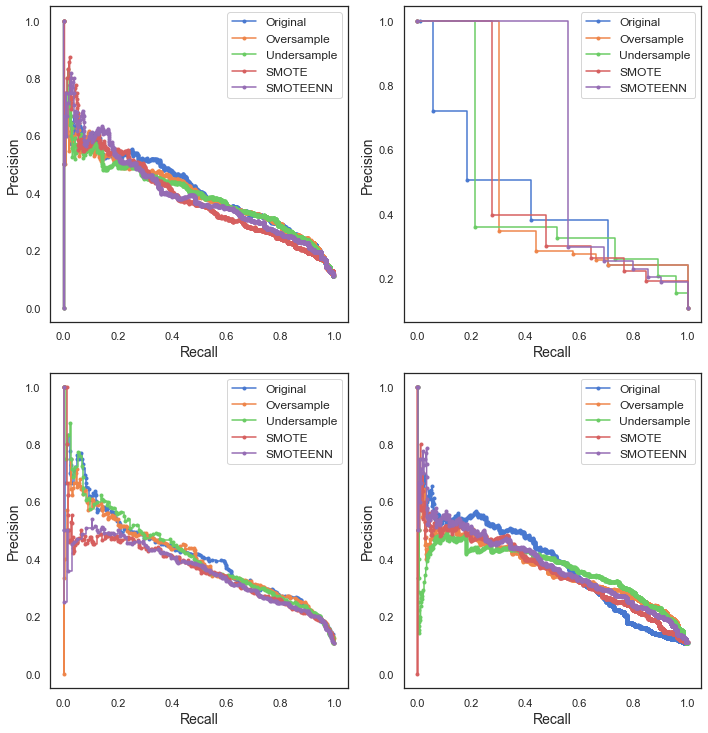

In [49]:
#precision recall curves using different sampling models using logistic regression, KNN, Random forest Classifier and 
#Support Vector Classifier
plt.subplots(figsize=(10,20))
MLA = (lr, knn, rf, svc)
for i, model in enumerate(MLA):
    plt.subplot(len(MLA),2,i+1)
    resample_plots(X_train, y_train, 'Original')
    resample_plots(os_X, os_y, 'Oversample')
    resample_plots(us_X, us_y, 'Undersample')
    resample_plots(smote_X, smote_y, 'SMOTE')
    resample_plots(smoteenn_X, smoteenn_y, 'SMOTEENN')

## Hyperparameter Tuning

In [50]:
#create an empty dataframe to record our results
model_compare = pd.DataFrame(columns=['Model', 'Sampling', 'Precision', 'Recall', 'PRC_AUC', 'ROC_AUC'])
model_compare

,Model,Sampling,Precision,Recall,PRC_AUC,ROC_AUC


In [51]:
#make a pipeline that selects best features, performs oversampling and then Logistic Regression
steps = [('selectkbest', SelectKBest(f_classif)),('ros',RandomOverSampler(random_state=42)),
         ('LR', LogisticRegression(random_state=42))]

pipeline = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]
params = [{'LR__C':[.001,.01,.1,1,10,100], 'selectkbest__k': k}]

lros_cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

lros_cv.fit(X_train, y_train)\

y_pred = lros_cv.predict(X_val)

y_predprob = lros_cv.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(lros_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_pred)
print('Area under ROC: %.4f'%(auc(fp, tp)))

model_compare = model_compare.append({'Model': 'Logistic Regression',
                                      'Sampling': 'Oversampled',
                                      'Precision': precision_score(y_val, y_pred),
                                      'Recall': recall_score(y_val, y_pred),
                                      'PRC_AUC': auc(recall, precision),
                                      'ROC_AUC': auc(fp, tp)},
                                     ignore_index=True)

              precision    recall  f1-score   support

           0       0.97      0.75      0.85      2584
           1       0.28      0.80      0.42       314

    accuracy                           0.76      2898
   macro avg       0.62      0.78      0.63      2898
weighted avg       0.89      0.76      0.80      2898

Tuned Model Parameters: {'LR__C': 0.1, 'selectkbest__k': 18}

Confusion Matrix: 
 [[1938  646]
 [  62  252]]

Precision: 0.2806
Recall: 0.8025

Area under PRC: 0.3923
Area under ROC: 0.7763


In [52]:
#make a pipeline that selects best features, performs undersampling and then Logistic Regression
steps = [('selectkbest', SelectKBest(f_classif)),('rus',RandomUnderSampler(random_state=42)),
         ('LR', LogisticRegression(random_state=42))]

pipeline = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]

params = [{'LR__C':[.001,.01,.1,1,10,100], 'selectkbest__k': k}]

lrus_cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

lrus_cv.fit(X_train, y_train)

y_pred = lrus_cv.predict(X_val)

y_predprob = lrus_cv.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(lrus_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_pred)
print('Area under ROC: %.4f'%(auc(fp, tp)))

model_compare = model_compare.append({'Model': 'Logistic Regression',
                                      'Sampling': 'Undersampled',
                                      'Precision': precision_score(y_val, y_pred),
                                      'Recall': recall_score(y_val, y_pred),
                                      'PRC_AUC': auc(recall, precision),
                                      'ROC_AUC': auc(fp, tp)},
                                     ignore_index=True)

              precision    recall  f1-score   support

           0       0.96      0.69      0.80      2584
           1       0.23      0.78      0.36       314

    accuracy                           0.70      2898
   macro avg       0.60      0.73      0.58      2898
weighted avg       0.88      0.70      0.75      2898

Tuned Model Parameters: {'LR__C': 0.001, 'selectkbest__k': 2}

Confusion Matrix: 
 [[1781  803]
 [  70  244]]

Precision: 0.2330
Recall: 0.7771

Area under PRC: 0.3119
Area under ROC: 0.7332


In [54]:
#make a pipeline that selects best features, performs SMOTEENN and then Logistic Regression
steps = [('selectkbest', SelectKBest(f_classif)),('smoteenn',SMOTEENN(random_state=42)),
         ('KNN', KNeighborsClassifier())]

pipeline = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]

params = [{'selectkbest__k': k, 'KNN__n_neighbors': [45, 50, 55]}]

knnsmo_cv = GridSearchCV(pipeline, params, cv=2, scoring='recall')

knnsmo_cv.fit(X_train, y_train)

y_pred = knnsmo_cv.predict(X_val)

y_predprob = knnsmo_cv.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(knnsmo_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_pred)
print('Area under ROC: %.4f'%(auc(fp, tp)))

model_compare = model_compare.append({'Model': 'KNeighbors Classifier',
                                      'Sampling': 'SMOTEENN',
                                      'Precision': precision_score(y_val, y_pred),
                                      'Recall': recall_score(y_val, y_pred),
                                      'PRC_AUC': auc(recall, precision),
                                      'ROC_AUC': auc(fp, tp)},
                                     ignore_index=True)

              precision    recall  f1-score   support

           0       0.98      0.60      0.75      2584
           1       0.22      0.90      0.35       314

    accuracy                           0.64      2898
   macro avg       0.60      0.75      0.55      2898
weighted avg       0.90      0.64      0.70      2898

Tuned Model Parameters: {'KNN__n_neighbors': 55, 'selectkbest__k': 23}

Confusion Matrix: 
 [[1559 1025]
 [  31  283]]

Precision: 0.2164
Recall: 0.9013

Area under PRC: 0.4331
Area under ROC: 0.7523


In [55]:
#make a pipeline that selects best features, performs undersampling and then Logistic Regression
steps = [('selectkbest', SelectKBest(f_classif)), ('ros',RandomOverSampler(random_state=42)),
         ('RF', RandomForestClassifier(random_state=42))]

pipeline = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]

params = [{'selectkbest__k': k, 'RF__n_estimators':[200]}]

rfos_cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

rfos_cv.fit(X_train, y_train)

y_pred = rfos_cv.predict(X_val)

y_predprob = rfos_cv.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(rfos_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_pred)
print('Area under ROC: %.4f'%(auc(fp, tp)))

model_compare = model_compare.append({'Model': 'Random Forest',
                                      'Sampling': 'Oversampled',
                                      'Precision': precision_score(y_val, y_pred),
                                      'Recall': recall_score(y_val, y_pred),
                                      'PRC_AUC': auc(recall, precision),
                                      'ROC_AUC': auc(fp, tp)},
                                     ignore_index=True)

              precision    recall  f1-score   support

           0       0.96      0.69      0.80      2584
           1       0.22      0.74      0.34       314

    accuracy                           0.69      2898
   macro avg       0.59      0.71      0.57      2898
weighted avg       0.88      0.69      0.75      2898

Tuned Model Parameters: {'RF__n_estimators': 200, 'selectkbest__k': 1}

Confusion Matrix: 
 [[1778  806]
 [  82  232]]

Precision: 0.2235
Recall: 0.7389

Area under PRC: 0.2832
Area under ROC: 0.7135


In [56]:
#make a pipeline that selects best features, performs undersampling and then Support Vector Classifier
steps = [('selectkbest', SelectKBest(f_classif)), ('rus', RandomUnderSampler(random_state=42)),
         ('SVC', SVC(random_state=42, probability=True))]

pipeline = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]

params = [{'selectkbest__k': k, 'SVC__C': [0.1, 0.01], 'SVC__kernel': ['linear', 'rbf']}]

svcus_cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

svcus_cv.fit(X_train, y_train)

y_pred = svcus_cv.predict(X_val)

y_predprob = svcus_cv.predict_proba(X_val)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(svcus_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_pred)
print('Area under ROC: %.4f'%(auc(fp, tp)))

model_compare = model_compare.append({'Model': 'Support Vector Classifier',
                                      'Sampling': 'Undersampled',
                                      'Precision': precision_score(y_val, y_pred),
                                      'Recall': recall_score(y_val, y_pred),
                                      'PRC_AUC': auc(recall, precision),
                                      'ROC_AUC': auc(fp, tp)},
                                     ignore_index=True)

              precision    recall  f1-score   support

           0       0.96      0.63      0.76      2584
           1       0.21      0.80      0.33       314

    accuracy                           0.65      2898
   macro avg       0.59      0.72      0.55      2898
weighted avg       0.88      0.65      0.72      2898

Tuned Model Parameters: {'SVC__C': 0.01, 'SVC__kernel': 'rbf', 'selectkbest__k': 6}

Confusion Matrix: 
 [[1637  947]
 [  62  252]]

Precision: 0.2102
Recall: 0.8025

Area under PRC: 0.2818
Area under ROC: 0.7180


In [57]:
#let's look at the results dataframe where we have sorted the values by recall
model_compare.sort_values(by='Recall', ascending=False)

,Model,Sampling,Precision,Recall,PRC_AUC,ROC_AUC
2,KNeighbors Classifier,SMOTEENN,0.216361,0.901274,0.433084,0.752301
0,Logistic Regression,Oversampled,0.280624,0.802548,0.392293,0.776274
4,Support Vector Classifier,Undersampled,0.210175,0.802548,0.281766,0.718031
1,Logistic Regression,Undersampled,0.233047,0.777070,0.311881,0.733156
3,Random Forest,Oversampled,0.223507,0.738854,0.283200,0.713467


We got high recall (0.80) and reasonably high precision(0.28) for Logistic Regression sampled using oversampling, we will be using this as out final model. But, first we will use it to get feature importance. 

## Feature importance

In [58]:
#get the important features for oversampled dataset predicted using Logistic Regression
coef_os = lros_cv.best_estimator_.named_steps['LR'].coef_[0]
selected_os = lros_cv.best_estimator_.named_steps.selectkbest.get_support()

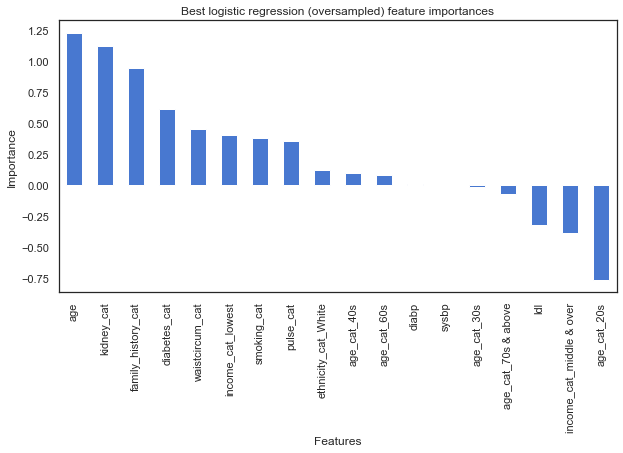

In [59]:
#plot the best estimated features
plt.subplots(figsize=(10, 5))
features = X_train.columns[selected_os]
imps = pd.Series(coef_os, index=features).sort_values(ascending=False)
imps.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Best logistic regression (oversampled) feature importances');

The predicted top features seem very reasonable with age, kidney function, family history, diabetes, waist circumference as the 5 most important fetaures.

In [60]:
#next we will select only the top 5 features showed above and predict y_val
steps = [('selectkbest', SelectKBest(f_classif)),('ros',RandomOverSampler()),
         ('LR', LogisticRegression())]

pipeline = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]
params = [{'LR__C':[.001,.01,.1,1,10,100], 'selectkbest__k': k}]

lros_cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

X_train_1 = X_train[['age', 'family_history_cat', 'diabetes_cat', 'kidney_cat', 'waistcircum_cat']]
X_val_1 = X_val[['age', 'family_history_cat', 'diabetes_cat', 'kidney_cat', 'waistcircum_cat']]

lros_cv.fit(X_train_1, y_train)

y_pred = lros_cv.predict(X_val_1)

y_predprob = lros_cv.predict_proba(X_val_1)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(lros_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_pred)
print('Area under ROC: %.4f'%(auc(fp, tp)))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82      2584
           1       0.25      0.79      0.38       314

    accuracy                           0.72      2898
   macro avg       0.61      0.75      0.60      2898
weighted avg       0.89      0.72      0.77      2898

Tuned Model Parameters: {'LR__C': 0.001, 'selectkbest__k': 5}

Confusion Matrix: 
 [[1835  749]
 [  66  248]]

Precision: 0.2487
Recall: 0.7898

Area under PRC: 0.3452
Area under ROC: 0.7500


The recall and precision are high after selecting the top 5 fetaures that makes our model pretty reliable. As our final goal to prepare widgets for individuals to enter their information for the model to predict their CVD risk, we will try to use the same features as above, except we will replace waistcircum_cat with smoking_cat.

In [89]:
steps = [('selectkbest', SelectKBest(f_classif)),('ros',RandomOverSampler()),
         ('LR', LogisticRegression())]

pipeline = Pipeline(steps)

k = [k+1 for k in range(len(X_train.columns))]
params = [{'LR__C':[.001,.01,.1,1,10,100], 'selectkbest__k': k}]

lros_cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

X_train_1 = X_train[['age', 'family_history_cat', 'diabetes_cat', 'kidney_cat', 'smoking_cat']]
X_val_1 = X_val[['age', 'family_history_cat', 'diabetes_cat', 'kidney_cat', 'smoking_cat']]

lros_cv.fit(X_train_1, y_train)

y_pred = lros_cv.predict(X_val_1)

y_predprob = lros_cv.predict_proba(X_val_1)[:,1]

print(classification_report(y_val, y_pred))
print("Tuned Model Parameters: {}".format(lros_cv.best_params_))
print("\nConfusion Matrix: \n", confusion_matrix(y_val, y_pred))
print('')
print('Precision: %.4f' %(precision_score(y_val, y_pred)))
print('Recall: %.4f' %(recall_score(y_val, y_pred)))
print('')
precision, recall, thresholds = precision_recall_curve(y_val, y_predprob)

print('Area under PRC: %.4f'%(auc(recall, precision)))

fp, tp, th = roc_curve(y_val, y_pred)
print('Area under ROC: %.4f'%(auc(fp, tp)))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82      2584
           1       0.25      0.79      0.38       314

    accuracy                           0.72      2898
   macro avg       0.61      0.75      0.60      2898
weighted avg       0.89      0.72      0.77      2898

Tuned Model Parameters: {'LR__C': 0.001, 'selectkbest__k': 5}

Confusion Matrix: 
 [[1845  739]
 [  66  248]]

Precision: 0.2513
Recall: 0.7898

Area under PRC: 0.3348
Area under ROC: 0.7519


In [79]:
datapath = '../data'
datapath_X_train = os.path.join(datapath, 'X_train.csv')
datapath_X_test = os.path.join(datapath, 'X_test.csv')
datapath_y_train = os.path.join(datapath, 'y_train.csv')
datapath_y_test = os.path.join(datapath, 'y_test.csv')
X_train.to_csv(datapath_X_train, index=False)
X_test.to_csv(datapath_X_test, index=False)
y_train.to_csv(datapath_y_train, index=False)
y_test.to_csv(datapath_y_test, index=False)

In [80]:
# Save the model
best_model = lros_cv.best_estimator_
best_model.version = 1.0
best_model.X_columns = [col for col in X_train.columns]
    
modelpath = '../models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
datapath_cvd_model = os.path.join(modelpath, 'CVD_prediction_model.pkl')
if not os.path.exists(datapath_cvd_model):
    with open(datapath_cvd_model, 'wb') as f:
        pickle.dump(best_model, f)

In [81]:
lros_cv.best_estimator_

Pipeline(steps=[('selectkbest', SelectKBest(k=5)), ('ros', RandomOverSampler()),
                ('LR', LogisticRegression(C=0.001))])

In [88]:
y_test.shape

(2898,)